# Live Auction

Recently the human bidders on the site are becoming increasingly frustrated with their inability to win auctions vs. robots. In order to rebuild customer happiness, the company is seeking to eliminate robot bidders from the site.

The goal of this project is to provide Live Auction with a model that will identify and flag bidders if they are a robot and prevent unfair bidding activity.

### Profile of a Robot

My hypothesis is that a robot bidder will have these characteristics:
1. They do lots of bids
2. Wait until the end of the auction
3. Bid in defined increments all the time for a given auction
4. Bid quickly
5. Execute multiple simultaneous bids.

In [6]:
############### Imports ################

# Basic Imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model Infrastructure
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.utils import resample
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import boto3
import io

In [7]:
############### Bring in Data ############
start_time = time.time()
s3 = boto3.client('s3')

#Bring in Training Data
obj = s3.get_object(Bucket='data-science-project-data', Key='Human_or_Robot/train.csv')
train = pd.read_csv(io.BytesIO(obj['Body'].read()))


# Bring in bids data
obj = s3.get_object(Bucket='data-science-project-data', Key='Human_or_Robot/bids.csv')
bids = pd.read_csv(io.BytesIO(obj['Body'].read()))

print("-- Execution time: %s seconds ---" % (time.time() - start_time))


-- Execution time: 23.331910371780396 seconds ---


## Exploratory Data Analysis

### Train Data

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2013 entries, 0 to 2012
Data columns (total 4 columns):
bidder_id          2013 non-null object
payment_account    2013 non-null object
address            2013 non-null object
outcome            2013 non-null float64
dtypes: float64(1), object(3)
memory usage: 63.0+ KB


In [47]:
#Serious class imbalance. Will need to deal with this when join the tables from the bids data onto this to create a final feature dataset
train['outcome'].value_counts()

0.0    1910
1.0     103
Name: outcome, dtype: int64

### Bids Data

In [41]:
bids.head(10)

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3
5,5,e8291466de91b0eb4e1515143c7f74dexy2yr,3vi4t,mobile,phone7,9759243157894736,ru,91.107.221.27,vasstdc27m7nks3
6,6,eef4c687daf977f64fc1d08675c44444raj3s,kjlzx,mobile,phone2,9759243210526315,th,152.235.155.159,j9nl1xmo6fqhcc6
7,7,ab056855c9ca9d36390feae1fa485883issyg,f5f6k,home goods,phone8,9759243210526315,id,3.210.112.183,hnt6hu93a3z1cpc
8,8,d600dc03b11e7d782e1e4dae091b084a1h5ch,h7jjx,home goods,phone9,9759243210526315,th,103.64.157.225,vasstdc27m7nks3
9,9,a58ace8b671a7531c88814bc86b2a34cf0crb,3zpkj,sporting goods,phone4,9759243210526315,za,123.28.123.226,vasstdc27m7nks3


In [9]:
bids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7656334 entries, 0 to 7656333
Data columns (total 9 columns):
bid_id         int64
bidder_id      object
auction        object
merchandise    object
device         object
time           int64
country        object
ip             object
url            object
dtypes: int64(2), object(7)
memory usage: 525.7+ MB


-- Execution time: 28.38271474838257 seconds ---


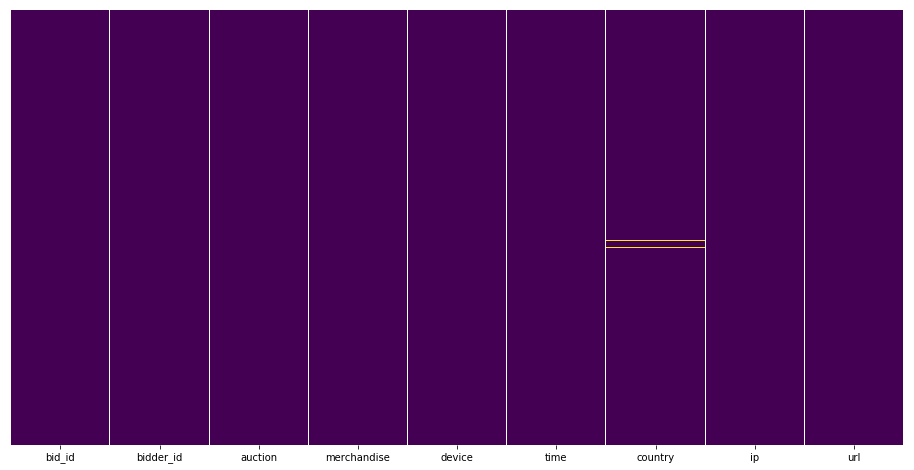

In [13]:
# Is there any missing data?
plt.figure(figsize=(16,8))
start_time = time.time()
sns.heatmap(bids.isnull(), yticklabels=False, cbar=False, cmap='viridis')
print("-- Execution time: %s seconds ---" % (time.time() - start_time))

Country is only missing a little. The rest is filled in.

### Bids Featrures Engineering

In [39]:
#### Create aggregate dataframe ########

start_time = time.time()
# Create bidder aggregation
bidder_aggregate = bids.groupby(['bidder_id'])['bid_id'].count().to_frame()
bidder_aggregate.columns = ['Total Bids']

# Add other columns
bidder_aggregate['Total Auctions'] = bids.groupby(['bidder_id'])['auction'].nunique()
bidder_aggregate['Number of Merchandise'] = bids.groupby(['bidder_id'])['merchandise'].nunique()
bidder_aggregate['Number of Device'] = bids.groupby(['bidder_id'])['device'].nunique()
bidder_aggregate['Number of IPs'] = bids.groupby(['bidder_id'])['ip'].nunique()
bidder_aggregate['Number of URLs'] = bids.groupby(['bidder_id'])['url'].nunique()

print("-- Execution time: %s seconds ---" % (time.time() - start_time))

-- Execution time: 64.63598465919495 seconds ---


In [40]:
bidder_aggregate.head()

,Total Bids,Total Auctions,Number of Merchandise,Number of Device,Number of IPs,Number of URLs
bidder_id,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1
002d229ffb247009810828f648afc2ef593rb,2,1,1,2,1,1
0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,3,1,3,3,2
00486a11dff552c4bd7696265724ff81yeo9v,20,13,1,8,10,7


#### Bidder- Auction

In [60]:
#Create this dataframe
bidder_auction = bids.groupby(['bidder_id','auction'])['time'].min().to_frame()
bidder_auction.columns = ['First Bid Time']
bidder_auction['Last Bid Time'] = bids.groupby(['bidder_id','auction'])['time'].max().to_frame()
bidder_auction['Bid Time Difference'] = bidder_auction['Last Bid Time'] - bidder_auction['First Bid Time']
bidder_auction['Number of Bids'] = bids.groupby(['bidder_id','auction'])['time'].count().to_frame()
bidder_auction['Mean Time per Bid'] = bidder_auction['Bid Time Difference']/bidder_auction['Number of Bids']


In [61]:
bidder_auction.head(20)

First Bid Time  \
bidder_id                             auction                     
001068c415025a009fee375a12cff4fcnht8y 4ifac    9706345052631578   
002d229ffb247009810828f648afc2ef593rb 2tdw2    9766744105263157   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny    9704553947368421   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6    9700605052631578   
                                      efh5o    9705974315789473   
                                      obbny    9640018631578947   
00486a11dff552c4bd7696265724ff81yeo9v 6plix    9632641157894736   
                                      9ul86    9635439947368421   
                                      cci6c    9638915315789473   
                                      drdr4    9695778631578947   
                                      eaz7i    9643095000000000   
                                      gst86    9633339684210526   
                                      lx0hm    9637993684210526   
                                      lz5gg    9643102000000000   
                                      nf1v1    9695819052631578   
                                      no958    9632636526315789   
                                      opnq4    9643292578947368   
                                      qvhei    9704030105263157   
                                      ss2rr    9708986368421052   
0051aef3fdeacdadba664b9b3b07e04e4coc6 d2q2z    9759271368421052   

                                                  Last Bid Time  \
bidder_id                             auction                     
001068c415025a009fee375a12cff4fcnht8y 4ifac    9706345052631578   
002d229ffb247009810828f648afc2ef593rb 2tdw2    9766744210526315   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny    9704553947368421   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6    9700605052631578   
                                      efh5o    9705974315789473   
                                      obbny    9640018631578947   
00486a11dff552c4bd7696265724ff81yeo9v 6plix    9636501894736842   
                                      9ul86    9635439947368421   
                                      cci6c    9638915315789473   
                                      drdr4    9696115947368421   
                                      eaz7i    9643095000000000   
                                      gst86    9640428842105263   
                                      lx0hm    9637993684210526   
                                      lz5gg    9644836894736842   
                                      nf1v1    9695819052631578   
                                      no958    9637993315789473   
                                      opnq4    9644657052631578   
                                      qvhei    9704030105263157   
                                      ss2rr    9708986368421052   
0051aef3fdeacdadba664b9b3b07e04e4coc6 d2q2z    9762607684210526   

                                               Bid Time Difference  \
bidder_id                             auction                        
001068c415025a009fee375a12cff4fcnht8y 4ifac                      0   
002d229ffb247009810828f648afc2ef593rb 2tdw2              105263158   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny                      0   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6                      0   
                                      efh5o                      0   
                                      obbny                      0   
00486a11dff552c4bd7696265724ff81yeo9v 6plix          3860736842106   
                                      9ul86                      0   
                                      cci6c                      0   
                                      drdr4           337315789474   
                                      eaz7i                      0   
                                      gst86          7089157894737   
                                      lx0hm                      0   
                                      lz5gg      

#### Auction

In [62]:
# Create Auction Dataframe
auction = bids.groupby(['auction'])['time'].min().to_frame()
auction.columns = ['Auction Started']

#Create other columns
auction['Auction Ended'] = bids.groupby(['auction'])['time'].min().to_frame()

In [63]:
auction.head()

,Auction Started,Auction Ended
auction,,
00270,9699049894736842,9699049894736842
008vv,9759369421052631,9759369421052631
00cwr,9695641631578947,9695641631578947
00do0,9759323842105263,9759323842105263
00hjy,9759410368421052,9759410368421052


Time Conversion

In [84]:
#Test dateconversion
import datetime
timestamp = 9759243157894736
date = date = datetime.datetime.fromtimestamp(timestamp / 1e13)
date

datetime.datetime(1970, 1, 1, 0, 16, 15, 924316)

In [85]:
timestamp = 9759243210526315
date = date = datetime.datetime.fromtimestamp(timestamp / 1e13)
date

datetime.datetime(1970, 1, 1, 0, 16, 15, 924321)

In [88]:
bids['Time Shift'] = bids['time'].diff()

In [96]:
bids.head(10)

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,Time Shift
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3,NaN
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,0.0
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3,0.0
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3,0.0
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3,0.0
5,5,e8291466de91b0eb4e1515143c7f74dexy2yr,3vi4t,mobile,phone7,9759243157894736,ru,91.107.221.27,vasstdc27m7nks3,0.0
6,6,eef4c687daf977f64fc1d08675c44444raj3s,kjlzx,mobile,phone2,9759243210526315,th,152.235.155.159,j9nl1xmo6fqhcc6,52631579.0
7,7,ab056855c9ca9d36390feae1fa485883issyg,f5f6k,home goods,phone8,9759243210526315,id,3.210.112.183,hnt6hu93a3z1cpc,0.0
8,8,d600dc03b11e7d782e1e4dae091b084a1h5ch,h7jjx,home goods,phone9,9759243210526315,th,103.64.157.225,vasstdc27m7nks3,0.0
9,9,a58ace8b671a7531c88814bc86b2a34cf0crb,3zpkj,sporting goods,phone4,9759243210526315,za,123.28.123.226,vasstdc27m7nks3,0.0


In [107]:
sorted_bids = bids.sort_values(by=['time'], ascending=True)
sorted_bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,Time Shift
2351187,2351187,76218e14c379c12d599dae9e1c00b61a3i5b2,6hpvy,sporting goods,phone1161,9631916842105263,cz,121.169.96.51,f33fl83l4vrg6is,-1.409684e+14
2351202,2351202,29c103503e1d6ace5626fb07a5ab0dafrtjvs,wpee4,jewelry,phone412,9631916842105263,ru,63.82.37.102,via8q041tf3xrke,0.000000e+00
2351201,2351201,0ea62aaa9c3ffcc6db584cb69c1f6c4bcripp,b6zck,mobile,phone99,9631916842105263,lt,181.144.42.116,vasstdc27m7nks3,0.000000e+00
2351200,2351200,6e178db6d17d21aa88aaca5bf15c2761lc500,jqx39,jewelry,phone99,9631916842105263,sa,174.12.78.255,omwhmwzvrn6ycq6,0.000000e+00
2351199,2351199,b7c4f67613c2af7e544f01359d4fccc7l5f7y,du967,office equipment,phone348,9631916842105263,tr,21.10.208.37,vasstdc27m7nks3,0.000000e+00


Earlist Time period is: 9631916842105263 and the smallest time difference is: 

In [122]:
sorted_bids['Time Shift'] = sorted_bids['time'].diff()
time_diff = sorted_bids['Time Shift'].value_counts().to_frame().reset_index()

In [123]:
#This is to be able to fully see the value instead of the exponent version
time_diff['converted'] = time_diff['index'].apply(lambda x: '%.3f' % x)

In [124]:
time_diff

,index,Time Shift,converted
0,0.000000e+00,6879805,0.000
1,5.263158e+07,734681,52631579.000
2,5.263158e+07,40817,52631578.000
3,1.052632e+08,904,105263158.000
4,1.052632e+08,105,105263157.000
5,1.578947e+08,10,157894737.000
6,1.578947e+08,3,157894736.000
7,5.002111e+13,2,50021105263158.000
8,5.263158e+08,1,526315790.000
9,4.210526e+08,1,421052632.000


In [125]:
#Want to be able to do grouping by some time period. To see how many auctions occured in that time span. Then could do group by bidder, time period,
# and then count how many auctions are going on. This will tell us how many simultaneous they are bidding on.